In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

from scipy import interp
from itertools import cycle

from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# upload data
df = pd.read_csv("LasVegasTripAdvisorReviews-Dataset.csv",sep=';') 
print(df.shape)
df.head(2)

(504, 20)


,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday


### Data Preprocess

In [3]:
def yesNo(x):
    if x == "YES":
        return 1
    else:
        return 0
    
def toOrd(str):
    x = 0
    for l in str:
        x += ord(l)
    return int(x)
#The ord() function returns an integer representing the Unicode character.

In [4]:
df['Gym'] = df['Gym'].apply(lambda x : yesNo(x))
df['Pool'] = df['Pool'].apply(lambda x : yesNo(x))
df['Tennis court'] = df['Tennis court'].apply(lambda x : yesNo(x))
df['Casino'] = df['Casino'].apply(lambda x : yesNo(x))
df['Free internet'] = df['Free internet'].apply(lambda x : yesNo(x))
df['Spa'] = df['Spa'].apply(lambda x : yesNo(x))

In [5]:
cols = ['Period of stay', 'Hotel name', 'User country',
         'Traveler type', 'User continent', 'Review month', 'Review weekday']

for y in cols:
    df[y]=df[y].apply(lambda x: toOrd(x))

print(df.shape)
df.head(2)

(504, 20)


,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,233,11,4,13,5,582,715,0,1,0,0,1,1,3367,3,3773,1245,9,730,852
1,233,119,21,75,3,582,844,0,1,0,0,1,1,3367,3,3773,1245,3,730,607


In [6]:
# create new feature "sport"
df['sport'] = 0 
index_sport = np.where((df['Pool'] == 1) & (df['Gym'] == 1) & (df['Tennis court'] == 1))[0]
df['sport'][index_sport]=1

In [7]:
# create new feature "entertainment"
df['ent'] = 0 
index_ent = np.where((df['Spa'] == 1) & (df['Casino'] == 1))[0]
df['ent'][index_ent] = 1

In [8]:
print(df.shape)
df.head(2)

(504, 22)


,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,...,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday,sport,ent
0,233,11,4,13,5,582,715,0,1,0,...,1,3367,3,3773,1245,9,730,852,0,0
1,233,119,21,75,3,582,844,0,1,0,...,1,3367,3,3773,1245,3,730,607,0,0


In [9]:
df1 = df[['User country', 'Nr. reviews','Nr. hotel reviews','Helpful votes','Period of stay',
         'Traveler type','Free internet','Hotel name','Hotel stars','Nr. rooms', 'User continent',
         'Member years','Review month','Review weekday', 'sport', 'ent', 'Score']]
df1.shape

(504, 17)

In [10]:
df1.head(5)

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Period of stay,Traveler type,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday,sport,ent,Score
0,233,11,4,13,582,715,1,3367,3,3773,1245,9,730,852,0,0,5
1,233,119,21,75,582,844,1,3367,3,3773,1245,3,730,607,0,0,3
2,233,36,9,25,628,810,1,3367,3,3773,1245,2,832,845,0,0,5
3,160,14,7,14,628,715,1,3367,3,3773,624,6,832,607,0,0,4
4,568,5,5,2,628,413,1,3367,3,3773,1245,7,491,735,0,0,4


In [11]:
df1.describe()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Period of stay,Traveler type,Free internet,Hotel name,Nr. rooms,User continent,Member years,Review month,Review weekday,sport,ent,Score
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,428.472222,48.130952,16.023810,31.751984,622.432540,747.087302,0.952381,2538.476190,2196.380952,983.555556,0.767857,631.750000,745.603175,0.238095,0.761905,4.123016
std,287.619301,74.996426,23.957953,48.520783,24.352273,88.604693,0.213170,888.959861,1285.476807,326.633988,80.692897,196.190532,124.713322,0.426341,0.426341,1.007302
min,160.000000,1.000000,0.000000,0.000000,582.000000,413.000000,0.000000,1158.000000,188.000000,382.000000,-1806.000000,295.000000,607.000000,0.000000,0.000000,1.000000
25%,233.000000,12.000000,5.000000,8.000000,628.000000,731.000000,1.000000,1899.000000,826.000000,624.000000,2.000000,473.250000,616.000000,0.000000,1.000000,4.000000
50%,233.000000,23.500000,9.000000,16.000000,629.500000,731.000000,1.000000,2447.000000,2700.000000,1245.000000,4.000000,675.500000,735.000000,0.000000,1.000000,4.000000
75%,568.000000,54.250000,18.000000,35.000000,635.250000,810.000000,1.000000,3330.000000,3025.000000,1245.000000,6.000000,800.750000,852.000000,0.000000,1.000000,5.000000
max,1881.000000,775.000000,263.000000,365.000000,648.000000,844.000000,1.000000,4469.000000,4027.000000,1253.000000,13.000000,935.000000,932.000000,1.000000,1.000000,5.000000


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 17 columns):
User country         504 non-null int64
Nr. reviews          504 non-null int64
Nr. hotel reviews    504 non-null int64
Helpful votes        504 non-null int64
Period of stay       504 non-null int64
Traveler type        504 non-null int64
Free internet        504 non-null int64
Hotel name           504 non-null int64
Hotel stars          504 non-null object
Nr. rooms            504 non-null int64
User continent       504 non-null int64
Member years         504 non-null int64
Review month         504 non-null int64
Review weekday       504 non-null int64
sport                504 non-null int64
ent                  504 non-null int64
Score                504 non-null int64
dtypes: int64(16), object(1)
memory usage: 67.0+ KB


In [13]:
# abnormal value_Member years
index1 = np.where(df1['Member years'] == -1806)[0]
df1['Member years'][index1] = round((sum(df1['Member years']) - df1['Member years'][index1])/(len(df1['Member years'])-1))

df1['Hotel stars'][df1['Hotel stars'].astype(str) == '3,5'] = 3.5
df1['Hotel stars'][df1['Hotel stars'].astype(str) == '4,5'] = 4.5
df1['Hotel stars'] = df1['Hotel stars'].astype(str).astype(float)

In [14]:
df1.describe()

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Period of stay,Traveler type,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday,sport,ent,Score
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,428.472222,48.130952,16.023810,31.751984,622.432540,747.087302,0.952381,2538.476190,4.142857,2196.380952,983.555556,4.359127,631.750000,745.603175,0.238095,0.761905,4.123016
std,287.619301,74.996426,23.957953,48.520783,24.352273,88.604693,0.213170,888.959861,0.774487,1285.476807,326.633988,2.925856,196.190532,124.713322,0.426341,0.426341,1.007302
min,160.000000,1.000000,0.000000,0.000000,582.000000,413.000000,0.000000,1158.000000,3.000000,188.000000,382.000000,0.000000,295.000000,607.000000,0.000000,0.000000,1.000000
25%,233.000000,12.000000,5.000000,8.000000,628.000000,731.000000,1.000000,1899.000000,3.500000,826.000000,624.000000,2.000000,473.250000,616.000000,0.000000,1.000000,4.000000
50%,233.000000,23.500000,9.000000,16.000000,629.500000,731.000000,1.000000,2447.000000,4.000000,2700.000000,1245.000000,4.000000,675.500000,735.000000,0.000000,1.000000,4.000000
75%,568.000000,54.250000,18.000000,35.000000,635.250000,810.000000,1.000000,3330.000000,5.000000,3025.000000,1245.000000,6.000000,800.750000,852.000000,0.000000,1.000000,5.000000
max,1881.000000,775.000000,263.000000,365.000000,648.000000,844.000000,1.000000,4469.000000,5.000000,4027.000000,1253.000000,13.000000,935.000000,932.000000,1.000000,1.000000,5.000000


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 17 columns):
User country         504 non-null int64
Nr. reviews          504 non-null int64
Nr. hotel reviews    504 non-null int64
Helpful votes        504 non-null int64
Period of stay       504 non-null int64
Traveler type        504 non-null int64
Free internet        504 non-null int64
Hotel name           504 non-null int64
Hotel stars          504 non-null float64
Nr. rooms            504 non-null int64
User continent       504 non-null int64
Member years         504 non-null float64
Review month         504 non-null int64
Review weekday       504 non-null int64
sport                504 non-null int64
ent                  504 non-null int64
Score                504 non-null int64
dtypes: float64(2), int64(15)
memory usage: 67.0 KB


In [16]:
df2 = df1.drop(['User continent', 'Review month', 'Review weekday'], axis=1)
print(df2.shape)
df2.head()

(504, 14)


,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Period of stay,Traveler type,Free internet,Hotel name,Hotel stars,Nr. rooms,Member years,sport,ent,Score
0,233,11,4,13,582,715,1,3367,3.0,3773,9.0,0,0,5
1,233,119,21,75,582,844,1,3367,3.0,3773,3.0,0,0,3
2,233,36,9,25,628,810,1,3367,3.0,3773,2.0,0,0,5
3,160,14,7,14,628,715,1,3367,3.0,3773,6.0,0,0,4
4,568,5,5,2,628,413,1,3367,3.0,3773,7.0,0,0,4


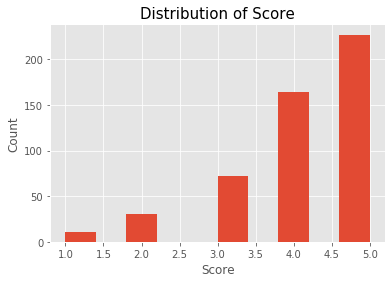

In [17]:
plt.hist(df2['Score'])
plt.title("Distribution of Score", fontsize=15)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

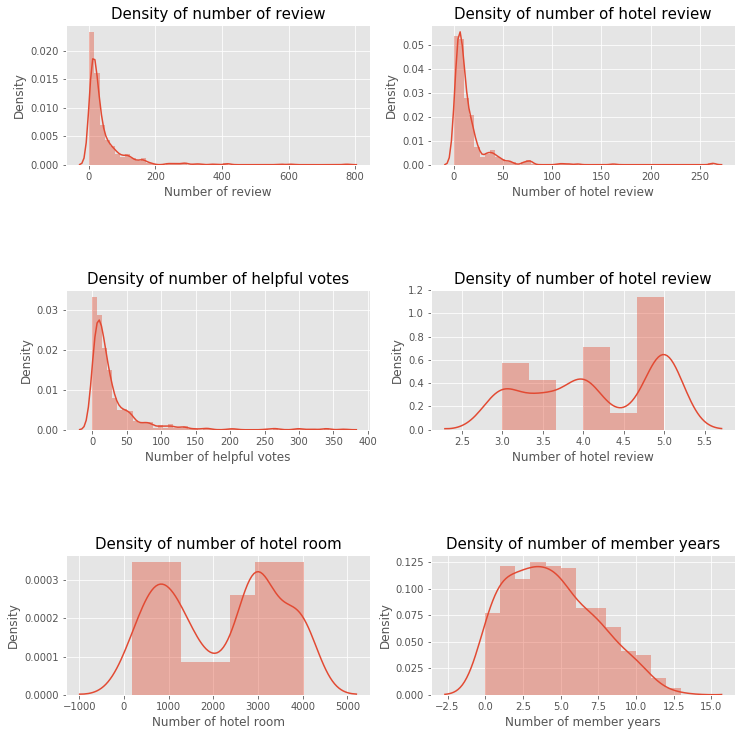

In [18]:
plt.figure(figsize = (12,12))

plt.subplot(321)
g = sns.distplot(df2['Nr. reviews'], hist=True)
g.set_title("Density of number of review", fontsize=15)
g.set_xlabel("Number of review", fontsize=12)
g.set_ylabel("Density", fontsize=12)

plt.subplot(322)
g1 = sns.distplot(df2['Nr. hotel reviews'], hist=True)
g1.set_title("Density of number of hotel review", fontsize=15)
g1.set_xlabel("Number of hotel review", fontsize=12)
g1.set_ylabel("Density", fontsize=12)

plt.subplot(323)
g2 = sns.distplot(df2['Helpful votes'], hist=True)
g2.set_title("Density of number of helpful votes", fontsize=15)
g2.set_xlabel("Number of helpful votes", fontsize=12)
g2.set_ylabel("Density", fontsize=12)

plt.subplot(324)
g3 = sns.distplot(df2['Hotel stars'], hist=True)
g3.set_title("Density of number of hotel review", fontsize=15)
g3.set_xlabel("Number of hotel review", fontsize=12)
g3.set_ylabel("Density", fontsize=12)

plt.subplot(325)
g4 = sns.distplot(df2['Nr. rooms'], hist=True)
g4.set_title("Density of number of hotel room", fontsize=15)
g4.set_xlabel("Number of hotel room", fontsize=12)
g4.set_ylabel("Density", fontsize=12)

plt.subplot(326)
g5 = sns.distplot(df2['Member years'], hist=True)
g5.set_title("Density of number of member years", fontsize=15)
g5.set_xlabel("Number of member years", fontsize=12)
g5.set_ylabel("Density", fontsize=12)

plt.subplots_adjust(hspace = 0.9, top = 0.9)

plt.show()

In [19]:
#log transformation
index_hv = np.where(df2['Helpful votes'] == 0)[0]
df2['Helpful votes'][index_hv] = 1
df2['log_Helpful votes'] = np.log(df2['Helpful votes'])

df2['log_Nr. reviews'] = np.log(df2['Nr. reviews'])

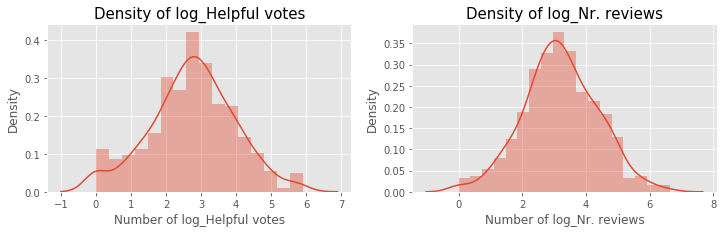

In [20]:
plt.figure(figsize = (12,3))

plt.subplot(121)
g = sns.distplot(df2['log_Helpful votes'], hist=True)
g.set_title("Density of log_Helpful votes", fontsize=15)
g.set_xlabel("Number of log_Helpful votes", fontsize=12)
g.set_ylabel("Density", fontsize=12)

plt.subplot(122)
g1 = sns.distplot(df2['log_Nr. reviews'] , hist=True)
g1.set_title("Density of log_Nr. reviews", fontsize=15)
g1.set_xlabel("Number of log_Nr. reviews", fontsize=12)
g1.set_ylabel("Density", fontsize=12)

plt.subplots_adjust(hspace = 0.9, top = 0.9)

plt.show()

## ANOVA + Chi-Square Test (in R)

In [21]:
df3 = df2.drop(['Helpful votes', 'Nr. reviews','Nr. hotel reviews','Period of stay',
                'Traveler type','sport','ent','log_Helpful votes'], axis=1)
print(df3.shape)
df3.head(2)

(504, 8)


,User country,Free internet,Hotel name,Hotel stars,Nr. rooms,Member years,Score,log_Nr. reviews
0,233,1,3367,3.0,3773,9.0,5,2.397895
1,233,1,3367,3.0,3773,3.0,3,4.779123


## Machine Learning

In [22]:
x = df3.drop(["Score"], axis = 1)
y = df3["Score"]

In [23]:
Xtr, Xte_tv, Ytr, Yte_tv = train_test_split(x, y, test_size = 0.3, random_state = 2)
Xte, Xtv, Yte, Ytv = train_test_split(Xte_tv, Yte_tv, test_size = 1/3, random_state = 2)

In [24]:
Ytr = label_binarize(Ytr, classes=[1,2,3,4,5])
Yte = label_binarize(Yte, classes=[1,2,3,4,5])
Ytv = label_binarize(Ytv, classes=[1,2,3,4,5])
n_classes = Ytr.shape[1] 

In [25]:
# SVM
svmploy = OneVsRestClassifier(svm.SVC(kernel='poly',C=0.9,degree=8,gamma='scale',probability=True))
svmrb = OneVsRestClassifier(svm.SVC(kernel='rbf',C=1,gamma='scale',probability=True))

In [26]:
yscore_ploy = svmploy.fit(Xtr, Ytr).decision_function(Xtv)
fpr_ploy = dict()
tpr_ploy = dict()
roc_auc_ploy = dict()
for i in range(n_classes):
    fpr_ploy[i], tpr_ploy[i], _ = roc_curve(Ytv[:, i], yscore_ploy[:, i])
    roc_auc_ploy[i] = auc(fpr_ploy[i], tpr_ploy[i])
    
yscore_rb = svmrb.fit(Xtr, Ytr).decision_function(Xtv)
fpr_rb = dict()
tpr_rb = dict()
roc_auc_rb = dict()
for i in range(n_classes):
    fpr_rb[i], tpr_rb[i], _ = roc_curve(Ytv[:, i], yscore_rb[:, i])
    roc_auc_rb[i] = auc(fpr_rb[i], tpr_rb[i])

In [27]:
# Compute micro-average ROC curve and ROC area 
fpr_ploy["micro"], tpr_ploy["micro"], _ = roc_curve(Ytv.ravel(), yscore_ploy.ravel())
roc_auc_ploy["micro"] = auc(fpr_ploy["micro"], tpr_ploy["micro"])

# Compute micro-average ROC curve and ROC area
fpr_rb["micro"], tpr_rb["micro"], _ = roc_curve(Ytv.ravel(), yscore_rb.ravel())
roc_auc_rb["micro"] = auc(fpr_rb["micro"], tpr_rb["micro"])

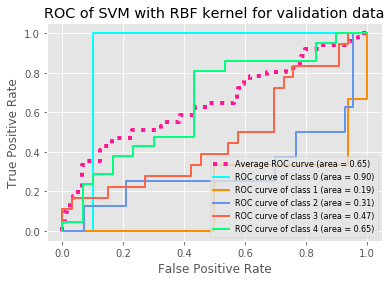

In [28]:
lw=2
plt.figure()
plt.plot(fpr_rb["micro"], tpr_rb["micro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rb["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', '#FF6347','#00FF7F'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rb[i], tpr_rb[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_rb[i]))

#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of SVM with RBF kernel for validation data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()

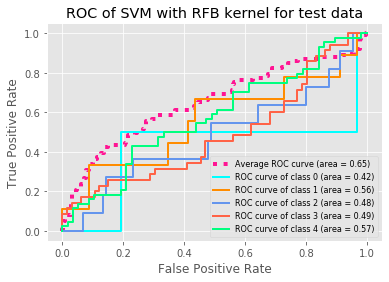

In [33]:
#pred test data
svmrb= OneVsRestClassifier(svm.SVC(kernel='rbf',C=1,gamma='scale',probability=True))
yscore_rb_pred = svmrb.fit(Xtr, Ytr).decision_function(Xte)
fpr_rb_pred  = dict()
tpr_rb_pred  = dict()
roc_auc_rb_pred  = dict()
for i in range(n_classes):
    fpr_rb_pred[i], tpr_rb_pred[i], _ = roc_curve(Yte[:, i], yscore_rb_pred[:, i])
    roc_auc_rb_pred[i] = auc(fpr_rb_pred [i], tpr_rb_pred [i])

fpr_rb_pred["micro"], tpr_rb_pred["micro"], _ = roc_curve(Yte.ravel(), yscore_rb_pred.ravel())
roc_auc_rb_pred["micro"] = auc(fpr_rb_pred["micro"], tpr_rb_pred["micro"])

lw=2
plt.figure()
plt.plot(fpr_rb_pred["micro"], tpr_rb_pred["micro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rb_pred["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', '#FF6347','#00FF7F'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rb_pred[i], tpr_rb_pred[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_rb_pred[i]))
   

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of SVM with RFB kernel for test data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()



In [34]:
ytehat = svmrb.predict(Xte) 
print("Classification Report of Test Data by SVM with RBF Kernel")
print(classification_report(Yte,ytehat))  

Classification Report of Test Data by SVM with RBF Kernel
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        35
           4       0.55      0.36      0.44        44

   micro avg       0.55      0.16      0.25       101
   macro avg       0.11      0.07      0.09       101
weighted avg       0.24      0.16      0.19       101
 samples avg       0.16      0.16      0.16       101



In [35]:
modrf5_2 = OneVsRestClassifier(RandomForestClassifier(random_state=95,max_depth=5, n_estimators=2,min_samples_split=2))   # Create random forest object
modrf5_3 = OneVsRestClassifier(RandomForestClassifier(random_state=95,max_depth=5, n_estimators=3,min_samples_split=2))   # Create random forest object
modrf5_4 = OneVsRestClassifier(RandomForestClassifier(random_state=95,max_depth=5, n_estimators=4,min_samples_split=2))   # Create random forest object
modrf3_2 = OneVsRestClassifier(RandomForestClassifier(random_state=95,max_depth=3, n_estimators=2,min_samples_split=2))   # Create random forest object
modrf3_3 = OneVsRestClassifier(RandomForestClassifier(random_state=95,max_depth=3, n_estimators=3,min_samples_split=2))   # Create random forest object
modrf3_4 = OneVsRestClassifier(RandomForestClassifier(random_state=95,max_depth=3, n_estimators=4,min_samples_split=2))   # Create random forest object

yscore5_2 = modrf5_2.fit(Xtr, Ytr).predict_proba(Xtv)
yscore5_3 = modrf5_3.fit(Xtr, Ytr).predict_proba(Xtv)
yscore5_4 = modrf5_4.fit(Xtr, Ytr).predict_proba(Xtv)
yscore3_2 = modrf3_2.fit(Xtr, Ytr).predict_proba(Xtv)
yscore3_3 = modrf3_3.fit(Xtr, Ytr).predict_proba(Xtv)
yscore3_4 = modrf3_4.fit(Xtr, Ytr).predict_proba(Xtv)

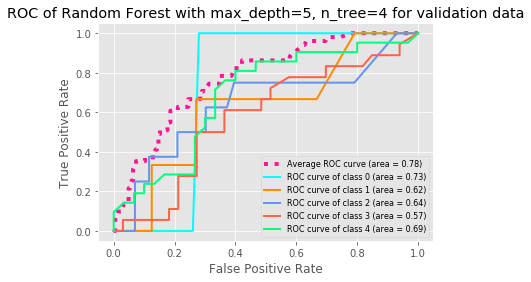

In [36]:
fpr_rf= dict()
tpr_rf= dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(Ytv[:, i], yscore5_4[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(Ytv.ravel(), yscore5_4.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

lw=2
plt.figure()
plt.plot(fpr_rf["micro"], tpr_rf["micro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rf["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', '#FF6347','#00FF7F'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_rf[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest with max_depth=5, n_tree=4 for validation data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()

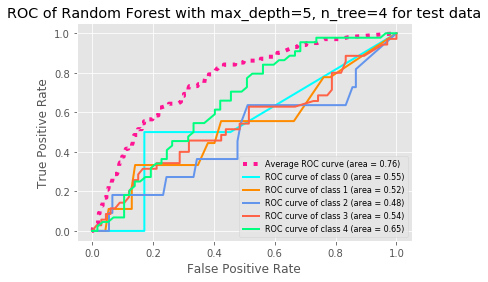

In [37]:
yscore_rf = modrf5_4.fit(Xtr, Ytr).predict_proba(Xte)
fpr_rf  = dict()
tpr_rf  = dict()
roc_auc_rf  = dict()
for i in range(n_classes):
    fpr_rf [i], tpr_rf[i], _ = roc_curve(Yte[:, i], yscore_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(Yte.ravel(), yscore_rf.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

lw=2
plt.figure()
plt.plot(fpr_rf["micro"], tpr_rf["micro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rf["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', '#FF6347','#00FF7F'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_rf[i]))
   
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Random Forest with max_depth=5, n_tree=4 for test data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()

In [38]:
ytehatrb = modrf5_3.predict(Xte) 
print("Classification Report of Test Data by RF")
print(classification_report(Yte,ytehatrb)) 

Classification Report of Test Data by RF
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        11
           3       0.45      0.14      0.22        35
           4       0.57      0.59      0.58        44

   micro avg       0.49      0.31      0.38       101
   macro avg       0.20      0.15      0.16       101
weighted avg       0.40      0.31      0.33       101
 samples avg       0.28      0.31      0.29       101



In [39]:
# neural network

modnn1 = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100,50,5,50,100), activation='logistic', solver='sgd', alpha=0.0001))   # Create random forest object
modnn2 = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100,50,5,50,100), activation='logistic', solver='lbfgs', alpha=0.0001))   # Create random forest object
modnn3 = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100,50,5,50,100), activation='tanh', solver='sgd', alpha=0.0001))   # Create random forest object
modnn4 = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100,50,5,50,100), activation='tanh', solver='lbfgs', alpha=0.0001))   # Create random forest object

yscore1 = modnn1.fit(Xtr, Ytr).predict_proba(Xtv)
yscore2 = modnn2.fit(Xtr, Ytr).predict_proba(Xtv)
yscore3 = modnn3.fit(Xtr, Ytr).predict_proba(Xtv)
yscore4 = modnn4.fit(Xtr, Ytr).predict_proba(Xtv)


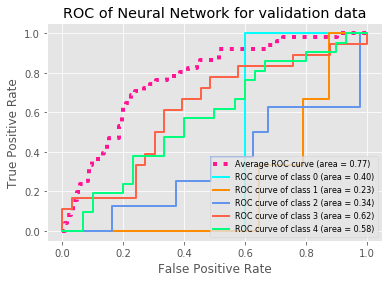

In [40]:
fpr_nn  = dict()
tpr_nn  = dict()
roc_auc_nn  = dict()
for i in range(n_classes):
    fpr_nn[i], tpr_nn[i], _ = roc_curve(Ytv[:, i], yscore2[:, i])
    roc_auc_nn[i] = auc(fpr_nn[i], tpr_nn[i])

fpr_nn["micro"], tpr_nn["micro"], _ = roc_curve(Ytv.ravel(), yscore2.ravel())
roc_auc_nn["micro"] = auc(fpr_nn["micro"], tpr_nn["micro"])

lw=2
plt.figure()
plt.plot(fpr_nn["micro"], tpr_nn["micro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_nn["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', '#FF6347','#00FF7F'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_nn[i], tpr_nn[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_nn[i]))
   
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Neural Network for validation data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()

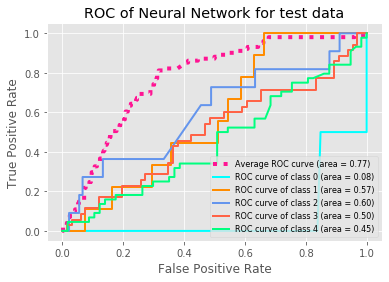

In [41]:
yscore_nn = modnn3.fit(Xtr, Ytr).predict_proba(Xte)
fpr_rf  = dict()
tpr_rf  = dict()
roc_auc_rf  = dict()
for i in range(n_classes):
    fpr_rf [i], tpr_rf[i], _ = roc_curve(Yte[:, i], yscore_nn[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Compute micro-average ROC curve and ROC area (method 1)
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(Yte.ravel(), yscore_nn.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

lw=2
plt.figure()
plt.plot(fpr_rf["micro"], tpr_rf["micro"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_rf["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', '#FF6347','#00FF7F'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_rf[i]))
   
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Neural Network for test data')
plt.legend(loc="lower right",prop = {'size':8})
plt.show()